# Load the libraries

In [1]:
import os
import folium
import pandas as pd
import seaborn as sns
import geopandas as gpd
import plotly.express as px
import matplotlib.pyplot as plt
from shapely.geometry import MultiPolygon, Polygon
from shapely.wkt import loads, dumps
from matplotlib import cm
from matplotlib.colors import Normalize, rgb2hex
import branca
from branca.element import Element

# Import Datasets

In [2]:
# Load the datasets
neighbourhood_profiles_df = pd.read_csv('pivoted_neighbourhood_profiles.csv') #neighborhood profiles with income
pollinateTO_df = pd.read_csv("PollinateTO_cleaned.csv")

# Define the directory where the CSV files are saved
save_directory = "Cleaned_neighborhood_csvs"

# List of filenames to open
filenames = [
    "geocoded_df.csv",
    "neighbourhoods_df_cleaned.csv",
    "parks_df.csv",
    "schools_df.csv",
    "filtered_gdf.csv"
]

# Dictionary to store the DataFrames
dataframes = {}

# Loop through the filenames and read the CSVs into DataFrames
for filename in filenames:
    file_path = os.path.join(save_directory, filename)
    dataframes[filename] = pd.read_csv(file_path)

# Access the loaded DataFrames by filename (example)
development_applications_geocoded_df = dataframes.get("Development_Applications_development_applications") # development applications
neighbourhoods_shapefiles_df = dataframes.get("neighbourhoods_df_cleaned.csv") #geometry shape file
parks_df = dataframes.get("parks_df.csv") # parks data
schools_df = dataframes.get("schools_df.csv") # school data
homeless_cleaned_gdf = dataframes.get("filtered_gdf.csv") # homeless shelter data

# Let's start with analysis of Neighborhood Incomes Data
Let's load the dataframe and see what we have

In [3]:
neighbourhood_profiles_df.head(15)

Unnamed: 0                          0  \
0                            _id                          1   
1                       Category  Neighbourhood Information   
2                          Topic  Neighbourhood Information   
3                 Characteristic       Neighbourhood Number   
4                City of Toronto                        NaN   
5                Agincourt North                      129.0   
6   Agincourt South-Malvern West                      128.0   
7                      Alderwood                       20.0   
8                          Annex                       95.0   
9              Banbury-Don Mills                       42.0   
10                Bathurst Manor                       34.0   
11           Bay Street Corridor                       76.0   
12               Bayview Village                       52.0   
13         Bayview Woods-Steeles                       49.0   
14          Bedford Park-Nortown                       39.0   

                           2                             3  \
0                          3                          2099   
1                 Population                        Income   
2   Population and dwellings  Income of households in 2015   
3           Population, 2016            $10,000 to $14,999   
4                  2731571.0                       73630.0   
5                    29113.0                         325.0   
6                    23757.0                         400.0   
7                    12054.0                         160.0   
8                    30526.0                        1315.0   
9                    27695.0                         480.0   
10                   15873.0                         305.0   
11                   25797.0                        1485.0   
12                   21396.0                         580.0   
13                   13154.0                         165.0   
14                   23236.0                         295.0   

                               4                             5  \
0                           2101                          2109   
1                         Income                        Income   
2   Income of households in 2015  Income of households in 2015   
3           $100,000 to $124,999          $125,000 to $149,999   
4                       194830.0                      126560.0   
5                         1890.0                        1105.0   
6                         1490.0                         845.0   
7                         1125.0                         925.0   
8                         2425.0                        1685.0   
9                         2165.0                        1440.0   
10                        1175.0                         775.0   
11                        1965.0                        1325.0   
12                        1655.0                        1120.0   
13                         950.0                         690.0   
14                        1325.0                         975.0   

                               6                             7  \
0                           2081                          1343   
1                         Income                        Income   
2   Income of households in 2015  Income of households in 2015   
3             $15,000 to $19,999          $150,000 to $199,999   
4                       109955.0                      188995.0   
5                          900.0                        1105.0   
6                          540.0                         900.0   
7                          175.0                        1030.0   
8                         1525.0                        3895.0   
9                          835.0                        2850.0   
10                         845.0                        1140.0   
11                        1410.0                        1885.0   
12                         685.0                        1650.0   
13                         275.0       

Let's remove the row with city of Toronto values since we are looking at information at neighborhood level. 

In [4]:
# Drop the rows with indices 0, 1, 2, and 4
neighbourhood_profiles_df = neighbourhood_profiles_df.drop(index=[0, 1, 2, 4])

# Verify the rows have been removed
neighbourhood_profiles_df.head(5)

Unnamed: 0                     0                 2  \
3                Characteristic  Neighbourhood Number  Population, 2016   
5               Agincourt North                 129.0           29113.0   
6  Agincourt South-Malvern West                 128.0           23757.0   
7                     Alderwood                  20.0           12054.0   
8                         Annex                  95.0           30526.0   

                    3                     4                     5  \
3  $10,000 to $14,999  $100,000 to $124,999  $125,000 to $149,999   
5               325.0                1890.0                1105.0   
6               400.0                1490.0                 845.0   
7               160.0                1125.0                 925.0   
8              1315.0                2425.0                1685.0   

                    6                     7                   8  \
3  $15,000 to $19,999  $150,000 to $199,999  $20,000 to $24,999   
5               900.0                1105.0               660.0   
6               540.0                 900.0               665.0   
7               175.0                1030.0               305.0   
8              1525.0                3895.0              1300.0   

                   9  ...                  11                  12  \
3  $200,000 and over  ...  $30,000 to $34,999  $35,000 to $39,999   
5              325.0  ...               870.0               965.0   
6              285.0  ...               765.0               835.0   
7              360.0  ...               325.0               380.0   
8             2670.0  ...              1155.0              1230.0   

                   13                  14                15  \
3  $40,000 to $44,999  $45,000 to $49,999  $5,000 to $9,999   
5               875.0               910.0             210.0   
6               840.0               860.0             270.0   
7               345.0               390.0              80.0   
8              1185.0              1170.0             970.0   

                   16                  17                  18  \
3  $50,000 to $59,999  $60,000 to $69,999  $70,000 to $79,999   
5              1730.0              1455.0              1330.0   
6              1630.0              1400.0              1225.0   
7               725.0               655.0               685.0   
8              2160.0              1960.0              1615.0   

                   19                  20  
3  $80,000 to $89,999  $90,000 to $99,999  
5              1165.0              1015.0  
6              1010.0               810.0  
7               585.0               515.0  
8              1465.0              1225.0  

[5 rows x 21 columns]

In [5]:
# Set the first row as the header
neighbourhood_profiles_df.columns = neighbourhood_profiles_df.iloc[0]

# Drop the first row now that it is set as the header
neighbourhood_profiles_df = neighbourhood_profiles_df.iloc[1:]

# Reset the index if needed
neighbourhood_profiles_df.reset_index(drop=True, inplace=True)

# Verify the changes
neighbourhood_profiles_df.head(5)

3                Characteristic Neighbourhood Number Population, 2016  \
0               Agincourt North                129.0          29113.0   
1  Agincourt South-Malvern West                128.0          23757.0   
2                     Alderwood                 20.0          12054.0   
3                         Annex                 95.0          30526.0   
4             Banbury-Don Mills                 42.0          27695.0   

3 $10,000 to $14,999 $100,000 to $124,999 $125,000 to $149,999  \
0              325.0               1890.0               1105.0   
1              400.0               1490.0                845.0   
2              160.0               1125.0                925.0   
3             1315.0               2425.0               1685.0   
4              480.0               2165.0               1440.0   

3 $15,000 to $19,999 $150,000 to $199,999 $20,000 to $24,999  \
0              900.0               1105.0              660.0   
1              540.0                900.0              665.0   
2              175.0               1030.0              305.0   
3             1525.0               3895.0             1300.0   
4              835.0               2850.0              825.0   

3 $200,000 and over  ... $30,000 to $34,999 $35,000 to $39,999  \
0             325.0  ...              870.0              965.0   
1             285.0  ...              765.0              835.0   
2             360.0  ...              325.0              380.0   
3            2670.0  ...             1155.0             1230.0   
4            1750.0  ...              905.0             1045.0   

3 $40,000 to $44,999 $45,000 to $49,999 $5,000 to $9,999 $50,000 to $59,999  \
0              875.0              910.0            210.0             1730.0   
1              840.0              860.0            270.0             1630.0   
2              345.0              390.0             80.0              725.0   
3             1185.0             1170.0            970.0             2160.0   
4             1015.0              975.0            305.0             2110.0   

3 $60,000 to $69,999 $70,000 to $79,999 $80,000 to $89,999 $90,000 to $99,999  
0             1455.0             1330.0             1165.0             1015.0  
1             1400.0             1225.0             1010.0              810.0  
2              655.0              685.0              585.0              515.0  
3             1960.0             1615.0             1465.0             1225.0  
4             1885.0             1570.0             1345.0             1200.0  

[5 rows x 21 columns]

In [6]:
# Explicitly make a copy to avoid SettingWithCopyWarning
neighbourhood_profiles_df = neighbourhood_profiles_df.copy()

# Rename the column 'Characteristic' to 'Neighbourhood Name'
neighbourhood_profiles_df.rename(columns={"Characteristic": "Neighbourhood Name"}, inplace=True)

# Verify the change
neighbourhood_profiles_df.head()

3            Neighbourhood Name Neighbourhood Number Population, 2016  \
0               Agincourt North                129.0          29113.0   
1  Agincourt South-Malvern West                128.0          23757.0   
2                     Alderwood                 20.0          12054.0   
3                         Annex                 95.0          30526.0   
4             Banbury-Don Mills                 42.0          27695.0   

3 $10,000 to $14,999 $100,000 to $124,999 $125,000 to $149,999  \
0              325.0               1890.0               1105.0   
1              400.0               1490.0                845.0   
2              160.0               1125.0                925.0   
3             1315.0               2425.0               1685.0   
4              480.0               2165.0               1440.0   

3 $15,000 to $19,999 $150,000 to $199,999 $20,000 to $24,999  \
0              900.0               1105.0              660.0   
1              540.0                900.0              665.0   
2              175.0               1030.0              305.0   
3             1525.0               3895.0             1300.0   
4              835.0               2850.0              825.0   

3 $200,000 and over  ... $30,000 to $34,999 $35,000 to $39,999  \
0             325.0  ...              870.0              965.0   
1             285.0  ...              765.0              835.0   
2             360.0  ...              325.0              380.0   
3            2670.0  ...             1155.0             1230.0   
4            1750.0  ...              905.0             1045.0   

3 $40,000 to $44,999 $45,000 to $49,999 $5,000 to $9,999 $50,000 to $59,999  \
0              875.0              910.0            210.0             1730.0   
1              840.0              860.0            270.0             1630.0   
2              345.0              390.0             80.0              725.0   
3             1185.0             1170.0            970.0             2160.0   
4             1015.0              975.0            305.0             2110.0   

3 $60,000 to $69,999 $70,000 to $79,999 $80,000 to $89,999 $90,000 to $99,999  
0             1455.0             1330.0             1165.0             1015.0  
1             1400.0             1225.0             1010.0              810.0  
2              655.0              685.0              585.0              515.0  
3             1960.0             1615.0             1465.0             1225.0  
4             1885.0             1570.0             1345.0             1200.0  

[5 rows x 21 columns]

In [7]:
# Update income_ranges keys to match the current column names
income_ranges = {
    "$10,000 to $14,999": (10000, 14999),
    "$15,000 to $19,999": (15000, 19999),
    "$20,000 to $24,999": (20000, 24999),
    "$25,000 to $29,999": (25000, 29999),
    "$30,000 to $34,999": (30000, 34999),
    "$35,000 to $39,999": (35000, 39999),
    "$40,000 to $44,999": (40000, 44999),
    "$45,000 to $49,999": (45000, 49999),
    "$50,000 to $59,999": (50000, 59999),
    "$60,000 to $69,999": (60000, 69999),
    "$70,000 to $79,999": (70000, 79999),
    "$80,000 to $89,999": (80000, 89999),
    "$90,000 to $99,999": (90000, 99999),
    "$100,000 to $124,999": (100000, 124999),
    "$125,000 to $149,999": (125000, 149999),
    "$150,000 to $199,999": (150000, 199999),
    "$200,000 and over": (200000, 200000)  # Fixed upper bound
}

# Convert income-related columns to numeric
for col in income_ranges.keys():
    if col in neighbourhood_profiles_df.columns:
        neighbourhood_profiles_df[col] = pd.to_numeric(neighbourhood_profiles_df[col], errors='coerce')

# Prepare the new DataFrame
neighbourhood_income_and_population_df = neighbourhood_profiles_df[
    ["Neighbourhood Name", "Neighbourhood Number", "Population, 2016"]
].copy()

# Initialize variables to store lower and upper bound sums and total population
neighbourhood_income_and_population_df["Average Income (Lower Bound)"] = 0.0
neighbourhood_income_and_population_df["Average Income (Upper Bound)"] = 0.0

# Calculate the weighted income bounds for each neighborhood
for index, row in neighbourhood_profiles_df.iterrows():
    lower_bound_sum = 0
    upper_bound_sum = 0
    total_population = 0

    for col, (lower, upper) in income_ranges.items():
        if col in neighbourhood_profiles_df.columns and pd.notna(row[col]):
            population_in_bracket = row[col]
            if pd.notna(population_in_bracket):  # Handle missing values
                lower_bound_sum += population_in_bracket * lower
                upper_bound_sum += population_in_bracket * upper
                total_population += population_in_bracket

    # Calculate average bounds, avoiding division by zero
    if total_population > 0:
        avg_lower_bound = lower_bound_sum / total_population
        avg_upper_bound = upper_bound_sum / total_population
    else:
        avg_lower_bound = avg_upper_bound = 0

    # Assign calculated values to the new DataFrame
    neighbourhood_income_and_population_df.loc[index, "Average Income (Lower Bound)"] = avg_lower_bound
    neighbourhood_income_and_population_df.loc[index, "Average Income (Upper Bound)"] = avg_upper_bound

# Combine lower and upper bounds into a single column for readability
neighbourhood_income_and_population_df["Average Income"] = neighbourhood_income_and_population_df.apply(
    lambda x: f"{x['Average Income (Lower Bound)']:.0f} to {x['Average Income (Upper Bound)']:.0f}", axis=1
)

# Drop intermediate calculation columns
neighbourhood_income_and_population_df.drop(columns=["Average Income (Lower Bound)", "Average Income (Upper Bound)"], inplace=True)


# Display the first few rows of the DataFrame
neighbourhood_income_and_population_df.head(5)

3            Neighbourhood Name Neighbourhood Number Population, 2016  \
0               Agincourt North                129.0          29113.0   
1  Agincourt South-Malvern West                128.0          23757.0   
2                     Alderwood                 20.0          12054.0   
3                         Annex                 95.0          30526.0   
4             Banbury-Don Mills                 42.0          27695.0   

3  Average Income  
0  67836 to 80814  
1  66721 to 79304  
2  82589 to 98839  
3  82585 to 97409  
4  82435 to 97383

In [8]:
# Check for missing values in the new dataframe and verify the format of the "Population, 2016" column

# Check for missing values
missing_values = neighbourhood_income_and_population_df.isnull().sum()

# Check if "Population, 2016" is in the correct numeric format
population_dtype = neighbourhood_income_and_population_df["Population, 2016"].dtype

missing_values, population_dtype


(3
 Neighbourhood Name      0
 Neighbourhood Number    0
 Population, 2016        0
 Average Income          0
 dtype: int64,
 dtype('O'))

We need to convert the Population, 2016 column to a numeric format for visualizations. Let me fix this.

In [9]:
# Convert "Population, 2016" to numeric
neighbourhood_income_and_population_df["Population, 2016"] = pd.to_numeric(
    neighbourhood_income_and_population_df["Population, 2016"], errors="coerce"
)

# Verify the conversion and check for missing values again
population_dtype = neighbourhood_income_and_population_df["Population, 2016"].dtype
missing_values_after_conversion = neighbourhood_income_and_population_df.isnull().sum()

population_dtype, missing_values_after_conversion

(dtype('float64'),
 3
 Neighbourhood Name      0
 Neighbourhood Number    0
 Population, 2016        0
 Average Income          0
 dtype: int64)

In [10]:
# Create a new column for average income midpoints
neighbourhood_income_and_population_df["Average Income Midpoint"] = neighbourhood_income_and_population_df["Average Income"].apply(
    lambda x: (float(x.split(" to ")[0]) + float(x.split(" to ")[1])) / 2 if isinstance(x, str) else None
)

# Verify the new column
neighbourhood_income_and_population_df.head()

3            Neighbourhood Name Neighbourhood Number  Population, 2016  \
0               Agincourt North                129.0           29113.0   
1  Agincourt South-Malvern West                128.0           23757.0   
2                     Alderwood                 20.0           12054.0   
3                         Annex                 95.0           30526.0   
4             Banbury-Don Mills                 42.0           27695.0   

3  Average Income  Average Income Midpoint  
0  67836 to 80814                  74325.0  
1  66721 to 79304                  73012.5  
2  82589 to 98839                  90714.0  
3  82585 to 97409                  89997.0  
4  82435 to 97383                  89909.0

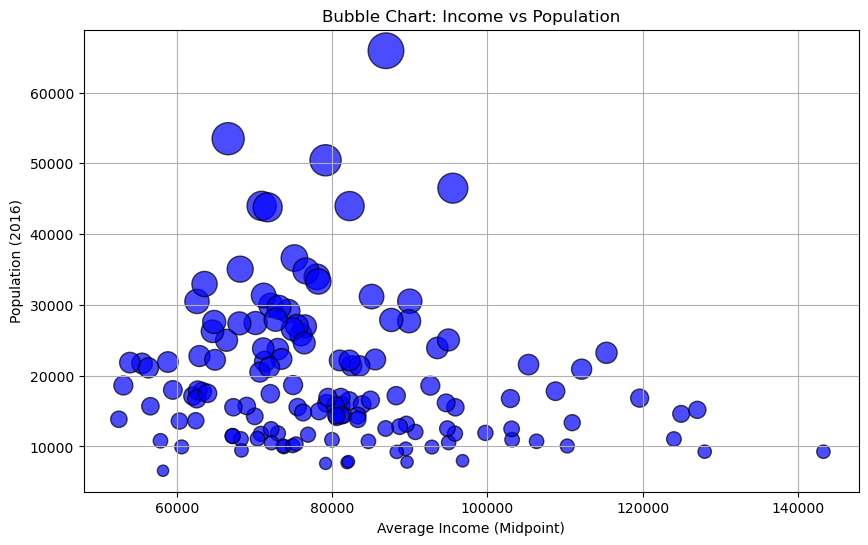

Chart saved as 'interactive_bubble_chart.html'


In [11]:
# Bubble Chart (corrected)
plt.figure(figsize=(10, 6))
plt.scatter(
    neighbourhood_income_and_population_df["Average Income Midpoint"],
    neighbourhood_income_and_population_df["Population, 2016"],
    s=neighbourhood_income_and_population_df["Population, 2016"] / 100,  # Scale bubble size
    alpha=0.7,
    color="blue",
    edgecolor="k"
)
plt.title("Bubble Chart: Income vs Population")
plt.xlabel("Average Income (Midpoint)")
plt.ylabel("Population (2016)")
plt.grid(True)
plt.show()

# Interactive Visualization with Plotly (corrected)
fig = px.scatter(
    neighbourhood_income_and_population_df,
    x="Average Income Midpoint",
    y="Population, 2016",
    size="Population, 2016",
    color="Neighbourhood Name",
    hover_name="Neighbourhood Name",
    title="Neighbourhood Profiles: Income vs Population",
    labels={"Average Income Midpoint": "Average Income (Midpoint)", "Population, 2016": "Population (2016)"}
)
fig.show()
fig.write_html("interactive_bubble_chart.html")
print("Chart saved as 'interactive_bubble_chart.html'")

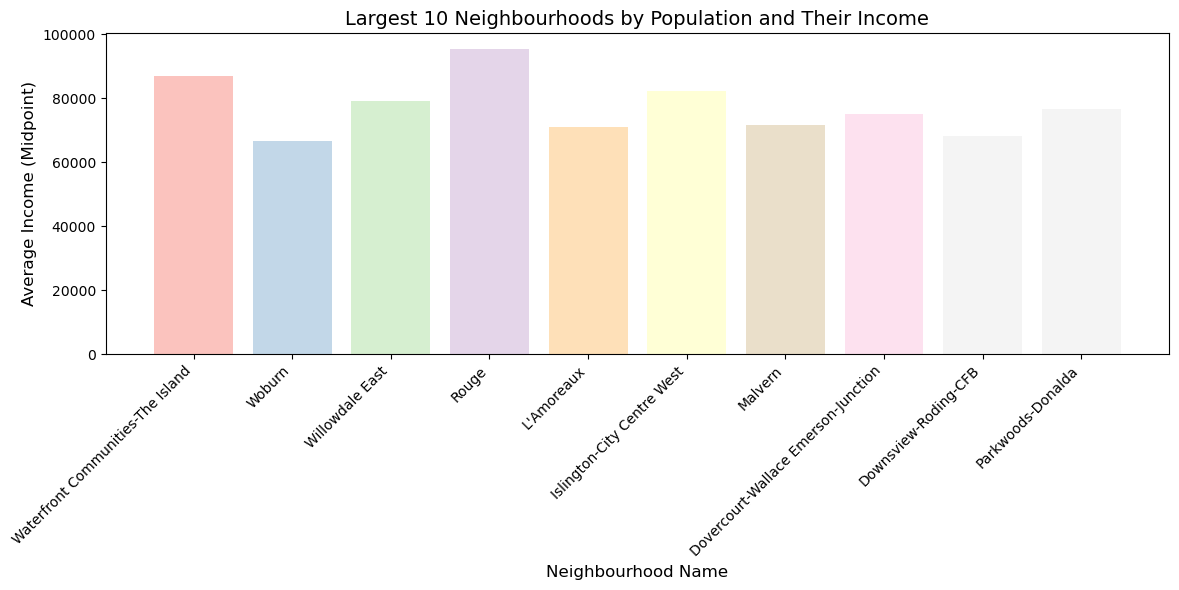

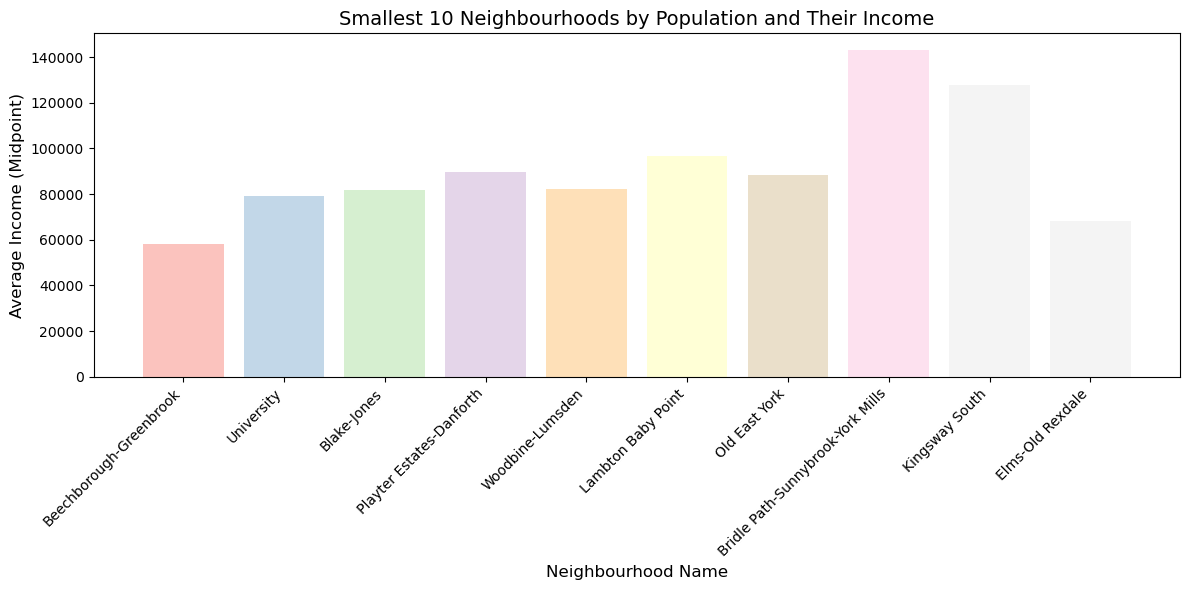

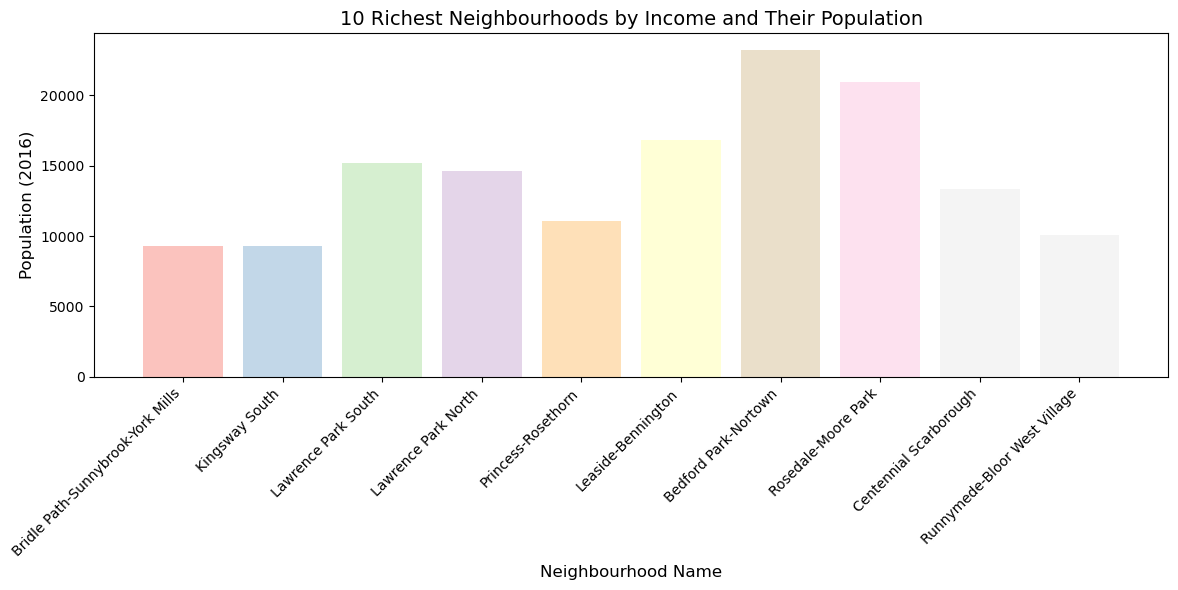

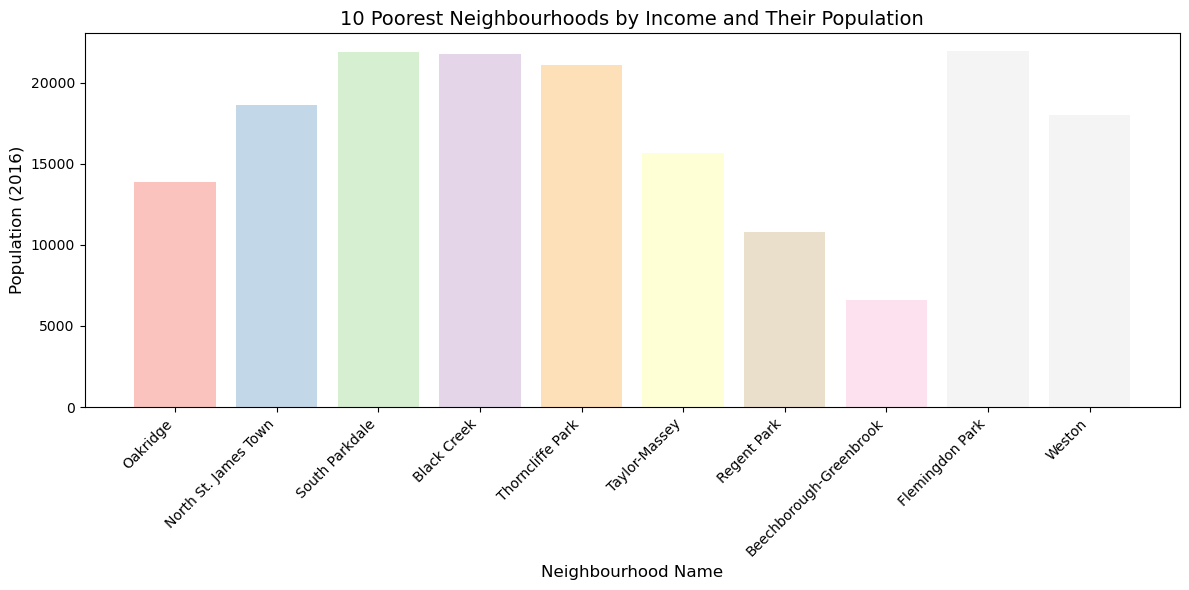

In [12]:
# Sort data for different visualizations
largest_neighbourhoods = neighbourhood_income_and_population_df.nlargest(10, "Population, 2016")
smallest_neighbourhoods = neighbourhood_income_and_population_df.nsmallest(10, "Population, 2016")
richest_neighbourhoods = neighbourhood_income_and_population_df.nlargest(10, "Average Income Midpoint")
poorest_neighbourhoods = neighbourhood_income_and_population_df.nsmallest(10, "Average Income Midpoint")

# Define a pastel color palette
colors = plt.cm.Pastel1(range(10))

# Largest 10 Neighbourhoods and their Income
plt.figure(figsize=(12, 6))
plt.bar(
    largest_neighbourhoods["Neighbourhood Name"],
    largest_neighbourhoods["Average Income Midpoint"],
    color=colors,
    alpha=0.8
)
plt.xticks(rotation=45, ha='right')
plt.title("Largest 10 Neighbourhoods by Population and Their Income", fontsize=14)
plt.xlabel("Neighbourhood Name", fontsize=12)
plt.ylabel("Average Income (Midpoint)", fontsize=12)
plt.tight_layout()
plt.show()

# Smallest 10 Neighbourhoods and their Income
plt.figure(figsize=(12, 6))
plt.bar(
    smallest_neighbourhoods["Neighbourhood Name"],
    smallest_neighbourhoods["Average Income Midpoint"],
    color=colors,
    alpha=0.8
)
plt.xticks(rotation=45, ha='right')
plt.title("Smallest 10 Neighbourhoods by Population and Their Income", fontsize=14)
plt.xlabel("Neighbourhood Name", fontsize=12)
plt.ylabel("Average Income (Midpoint)", fontsize=12)
plt.tight_layout()
plt.show()

# 10 Richest Neighbourhoods and their Population
plt.figure(figsize=(12, 6))
plt.bar(
    richest_neighbourhoods["Neighbourhood Name"],
    richest_neighbourhoods["Population, 2016"],
    color=colors,
    alpha=0.8
)
plt.xticks(rotation=45, ha='right')
plt.title("10 Richest Neighbourhoods by Income and Their Population", fontsize=14)
plt.xlabel("Neighbourhood Name", fontsize=12)
plt.ylabel("Population (2016)", fontsize=12)
plt.tight_layout()
plt.show()

# 10 Poorest Neighbourhoods and their Population
plt.figure(figsize=(12, 6))
plt.bar(
    poorest_neighbourhoods["Neighbourhood Name"],
    poorest_neighbourhoods["Population, 2016"],
    color=colors,
    alpha=0.8
)
plt.xticks(rotation=45, ha='right')
plt.title("10 Poorest Neighbourhoods by Income and Their Population", fontsize=14)
plt.xlabel("Neighbourhood Name", fontsize=12)
plt.ylabel("Population (2016)", fontsize=12)
plt.tight_layout()
plt.show()

In [13]:
# Combined Graph: Largest and Smallest 10 Neighbourhoods by Income
plt.figure(figsize=(14, 7))

# Plot Largest 10 Neighbourhoods
plt.bar(
    largest_neighbourhoods["Neighbourhood Name"],
    largest_neighbourhoods["Average Income Midpoint"],
    color="lightblue",
    label="Largest Neighbourhoods"
)

# Plot Smallest 10 Neighbourhoods
plt.bar(
    smallest_neighbourhoods["Neighbourhood Name"],
    smallest_neighbourhoods["Average Income Midpoint"],
    color="lightcoral",
    label="Smallest Neighbourhoods"
)

plt.xticks(rotation=45, ha='right')
plt.title("Largest and Smallest 10 Neighbourhoods by Income", fontsize=14)
plt.xlabel("Neighbourhood Name", fontsize=12)
plt.ylabel("Average Income (Midpoint)", fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

# Combined Graph: Richest and Poorest 10 Neighbourhoods by Population
plt.figure(figsize=(14, 7))

# Plot Richest 10 Neighbourhoods
plt.bar(
    richest_neighbourhoods["Neighbourhood Name"],
    richest_neighbourhoods["Population, 2016"],
    color="lightgreen",
    label="Richest Neighbourhoods"
)

# Plot Poorest 10 Neighbourhoods
plt.bar(
    poorest_neighbourhoods["Neighbourhood Name"],
    poorest_neighbourhoods["Population, 2016"],
    color="orange",
    label="Poorest Neighbourhoods"
)

plt.xticks(rotation=45, ha='right')
plt.title("Richest and Poorest 10 Neighbourhoods by Population", fontsize=14)
plt.xlabel("Neighbourhood Name", fontsize=12)
plt.ylabel("Population (2016)", fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()


# Now it is time to add toronto shapefile to this analysis

<Figure size 1200x800 with 0 Axes>

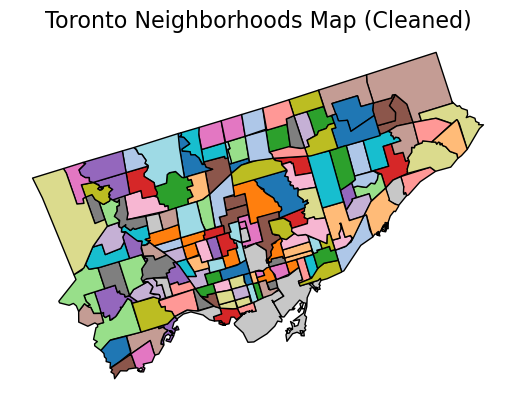

Cleaned GeoDataFrame exported to cleaned_neighbourhoods.geojson.


In [14]:
# Convert WKT strings to Shapely geometry objects
neighbourhoods_shapefiles_df['geometry'] = neighbourhoods_shapefiles_df['geometry'].apply(loads)

# Function to clean and decompose MultiPolygons into individual Polygons
def clean_geometries(geometry):
    if isinstance(geometry, MultiPolygon):
        return list(geometry.geoms)  # Decompose MultiPolygon
    elif isinstance(geometry, Polygon):
        return [geometry]  # Keep Polygon as a single item list
    else:
        return []  # Exclude unsupported geometry types

# Decompose MultiPolygons and rebuild the dataset
cleaned_rows = []
for idx, row in neighbourhoods_shapefiles_df.iterrows():
    geometries = clean_geometries(row['geometry'])
    for geom in geometries:
        new_row = row.copy()
        new_row['geometry'] = geom
        cleaned_rows.append(new_row)

# Create a new GeoDataFrame from the cleaned rows
neighbourhoods_simplified_gdf = gpd.GeoDataFrame(cleaned_rows, geometry='geometry')

# Set the CRS (Coordinate Reference System)
neighbourhoods_simplified_gdf.set_crs(epsg=4326, inplace=True)

# Simplify geometries for better performance
neighbourhoods_simplified_gdf['geometry'] = neighbourhoods_simplified_gdf['geometry'].simplify(tolerance=0.001, preserve_topology=True)

# Plot the cleaned geometries
plt.figure(figsize=(12, 8))
neighbourhoods_simplified_gdf.plot(column="AREA_NAME", legend=False, cmap="tab20", edgecolor="black")
plt.title("Toronto Neighborhoods Map (Cleaned)", fontsize=16)
plt.axis("off")
plt.show()

# Export the cleaned GeoDataFrame to a GeoJSON file for future use
output_geojson_path = "cleaned_neighbourhoods.geojson"
neighbourhoods_simplified_gdf.to_file(output_geojson_path, driver="GeoJSON")
print(f"Cleaned GeoDataFrame exported to {output_geojson_path}.")

Now let's overlay our diagram over toronto map.

In [15]:
# Convert to GeoDataFrame
toronto_hoods = gpd.GeoDataFrame(neighbourhoods_shapefiles_df, geometry='geometry')

# Set CRS for GeoDataFrame
toronto_hoods.set_crs(epsg=4326, inplace=True)

# Initialize a Folium map
toronto_map = folium.Map(location=[43.7, -79.4], zoom_start=11, tiles="CartoDB positron")

# Add neighborhood geometries to the map
for _, row in toronto_hoods.iterrows():
    # Add each neighborhood as a polygon on the map
    folium.GeoJson(
        row['geometry'],
        name=row.get('AREA_NAME', 'Unnamed Neighborhood'),
        tooltip=row.get('AREA_NAME', 'Unnamed Neighborhood')  # Show AREA_NAME on hover
    ).add_to(toronto_map)

# Display the map
toronto_map.save('toronto_neighborhoods_map.html')
print("Map saved as 'toronto_neighborhoods_map.html'")

Map saved as 'toronto_neighborhoods_map.html'


In [16]:
# Get unique neighborhood names from the shapefile data
shapefile_names = toronto_hoods["AREA_NAME"].str.strip().str.lower().unique()

# Get unique neighborhood names from the income data
income_names = neighbourhood_income_and_population_df["Neighbourhood Name"].str.strip().str.lower().unique()

print(f"Number of neighborhoods in shapefile: {len(shapefile_names)}")
print(f"Number of neighborhoods in income data: {len(income_names)}")

Number of neighborhoods in shapefile: 158
Number of neighborhoods in income data: 140


In [17]:
# Define the mapping dictionary
name_mapping = {
    "malvern": ["malvern east", "malvern west", "morningside heights"],
    "bendale": ["bendale glen andrew", "bendale south"],
    "cabbagetown south st james town": ["cabbagetown south stjames town"],
    "church yonge corridor": ["church wellesley"],
    "dovercourt wallace emerson junction": ["dovercourt village", "junction wallace emerson"],
    "downsview roding cfb": ["downtown yonge east", "oakdale beverley heights", "downsview"],
    "willowdale east": ["east willowdale", "yonge doris", "avondale"],
    "islington city centre west": ["islington"],
    "lamoreaux": ["lamoreaux west", "east lamoreaux"],
    "mimico (includes humber bay shores)": ["mimico queensway", "etobicoke city centre", "humber bay shores"],
    "north st james town": ["north stjames town", "south eglinton davisville"],
    "woburn": ["woburn north", "golfdale cedarbrae woburn"],
    "rouge": ["west rouge"],
    "bay street corridor": ["yonge bay corridor", "bay cloverhill", "downtown yonge east"],
    "niagara": ["west queen west", "fort york liberty village"],
    "mount pleasant west": ["north toronto"],
    "waterfront communities the island": ["harbourfront cityplace", "st lawrence east bayfront the islands"],
    "parkwoods donalda": ["fenside parkwoods", "parkwoods oconnor hills", "wellington place"]
}

# Standardize and map names using name_mapping
def standardize_and_map_names(name, mapping):
    if isinstance(name, str):
        # Standardize the name
        standardized_name = (
            name.strip()
            .lower()
            .replace("-", " ")
            .replace("'", "")
            .replace(".", "")
            .replace(",", "")
        )
        # Check if the name matches any variations in the mapping
        for key, variations in mapping.items():
            if standardized_name in variations:
                return key
        return standardized_name
    return None

# Apply the function to both dataframes
toronto_hoods["Mapped_NAME"] = toronto_hoods["AREA_NAME"].apply(
    lambda x: standardize_and_map_names(x, name_mapping)
)
neighbourhood_income_and_population_df["Mapped_NAME"] = neighbourhood_income_and_population_df["Neighbourhood Name"].apply(
    lambda x: standardize_and_map_names(x, name_mapping)
)

In [18]:
# Merge the two datasets on the Mapped_NAME column
merged_gdf = toronto_hoods.merge(
    neighbourhood_income_and_population_df,
    on="Mapped_NAME",
    how="left"
)

# Check for any mismatched entries
mismatched_entries = merged_gdf[merged_gdf.isnull().any(axis=1)]

print(f"Number of unmatched entries: {len(mismatched_entries)}")

Number of unmatched entries: 0


In [19]:
# Export unmatched entries for review
mismatched_entries.to_csv("unmatched_entries.csv", index=False)
print("Unmatched entries saved to 'unmatched_entries.csv'.")

Unmatched entries saved to 'unmatched_entries.csv'.


In [20]:
# Normalize the "Average Income Midpoint" for a color gradient
import matplotlib

# Create a linear color map for average income
colormap = matplotlib.cm.ScalarMappable(
    norm=matplotlib.colors.Normalize(
        vmin=merged_gdf["Average Income Midpoint"].min(),
        vmax=merged_gdf["Average Income Midpoint"].max()
    ),
    cmap="YlGnBu"
)

# Add polygons to the Folium map
for _, row in merged_gdf.iterrows():
    income = row["Average Income Midpoint"]
    color = (
        matplotlib.colors.rgb2hex(colormap.to_rgba(income))
        if not pd.isnull(income)
        else "#d3d3d3"  # Default color for unmatched neighborhoods
    )
    folium.GeoJson(
        row["geometry"],
        name=row["Mapped_NAME"],
        tooltip=folium.Tooltip(
            f"<b>Neighborhood:</b> {row['Mapped_NAME']}<br>"
            f"<b>Population:</b> {row['Population, 2016']}<br>"
            f"<b>Average Income:</b> {row['Average Income']}"
        ),
        style_function=lambda x, color=color: {"fillColor": color, "color": "black", "weight": 0.5, "fillOpacity": 0.7},
    ).add_to(toronto_map)

# Save the updated map
toronto_map.save("toronto_neighborhoods_income_map.html")
print("Map saved as 'toronto_neighborhoods_income_map.html'.")

Map saved as 'toronto_neighborhoods_income_map.html'.


# Now let's introduce pollinate TO to our analysis

In [21]:
pollinateTO_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149 entries, 0 to 148
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   _id                     149 non-null    int64  
 1   ID                      149 non-null    int64  
 2   YEAR_FUNDED             149 non-null    int64  
 3   GROUP_NAME              149 non-null    object 
 4   PROJECT_NAME            149 non-null    object 
 5   GARDEN_TYPE             149 non-null    object 
 6   NUMBER_OF_GARDENS       149 non-null    int64  
 7   ESTIMATED_GARDEN_SIZE   149 non-null    float64
 8   NEIGHBOURHOOD_NUMBER    149 non-null    int64  
 9   NIA_OR_EN               149 non-null    object 
 10  PRIMARY_LOCATION_NAME   149 non-null    object 
 11  PRIMARY_GARDEN_ADDRESS  149 non-null    object 
 12  POSTAL_CODE             149 non-null    object 
 13  IS_INDIGENOUS_GARDEN    149 non-null    object 
 14  WARD_NAME               149 non-null    ob

In [22]:
pollinateTO_df.head(15)

_id  ID  YEAR_FUNDED                                         GROUP_NAME  \
0     1   1         2020               Appleton Ave. Community Organization   
1     2   2         2020  Centre for Immigrant and Community Services (C...   
2     3   3         2020              Chester School Pollinator Garden Team   
3     4   4         2020                             CSPC - Transfiguration   
4     5   5         2020         Danforth Gardens Neighbourhood Association   
5     6   6         2020  David Hornell Junior School & Mimico Residents...   
6     7   7         2020                                          Evergreen   
7     8   8         2020                             FJR Pollinator Project   
8     9   9         2020       Garrison Creek Park Community Garden (GCPCG)   
9    10  10         2020  George Chuvalo Community Center & Christie Oss...   
10   11  11         2020                          Green Thumbs Growing Kids   
11   12  12         2020                        Greenland Pollinator Garden   
12   13  13         2020         Harbord Collegiate PARA Pollinator Gardens   
13   14  14         2020                          Hopewell Community Garden   
14   15  15         2020    King George Junior Public School Parent Council   

                                         PROJECT_NAME  \
0                   Appleton Ave. Pollinator Corridor   
1                        The ENRICH Pollinator Garden   
2                    Chester School Pollinator Garden   
3                   Transfiguration Pollinator Garden   
4   Danforth Gardens Neighbourhood Pollinator Corr...   
5                    David Hornell Pollinator Gardens   
6                   Pollinator Revitalization Project   
7                               FJR Pollinator Garden   
8              Garrison Creek Park Pollinator Gardens   
9                                        GCCC Gardens   
10                                       Flower Power   
11  Greenland Public School & Community Pollinator...   
12               Harbord Collegiate Pollinator Garden   
13                         Hopewell Pollinator Garden   
14                      King George Pollinator Garden   

                    GARDEN_TYPE  NUMBER_OF_GARDENS  ESTIMATED_GARDEN_SIZE  \
0   Multiple Front Yard Gardens                 18                1250.00   
1               Communal Garden                  4                 114.25   
2        School Learning Garden                  1                  34.00   
3        School Learning Garden                  1                  22.00   
4   Multiple Front Yard Gardens                  7                  28.00   
5        School Learning Garden                  3                 111.00   
6               Communal Garden                  6                 123.00   
7        School Learning Garden                  3                  46.50   
8                     City Park                  3                  48.00   
9               Communal Garden                  2                  34.00   
10       School Learning Garden                  3                5260.00   
11       School Learning Garden                  1                  37.20   
12       School Learning Garden                  3                 191.00   
13                    City Park                  1                 475.00   
14       School Learning Garden                  1                   4.50   

    NEIGHBOURHOOD_NUMBER NIA_OR_EN  \
0                     92      None   
1                    128      None   
2                     57      None   
3                      7      None   
4                    120      None   
5                    161      None   
6                     56      None   
7                     18      None   
8                     94      None   
9                    171      None   
10                    74      None   
11                    42      None   
12                    80      None   
13                   108      None   
14                    8

In [23]:
# Convert "YEAR_FUNDED" column to integer if it's not already
pollinateTO_df['YEAR_FUNDED'] = pd.to_numeric(pollinateTO_df['YEAR_FUNDED'], errors='coerce')

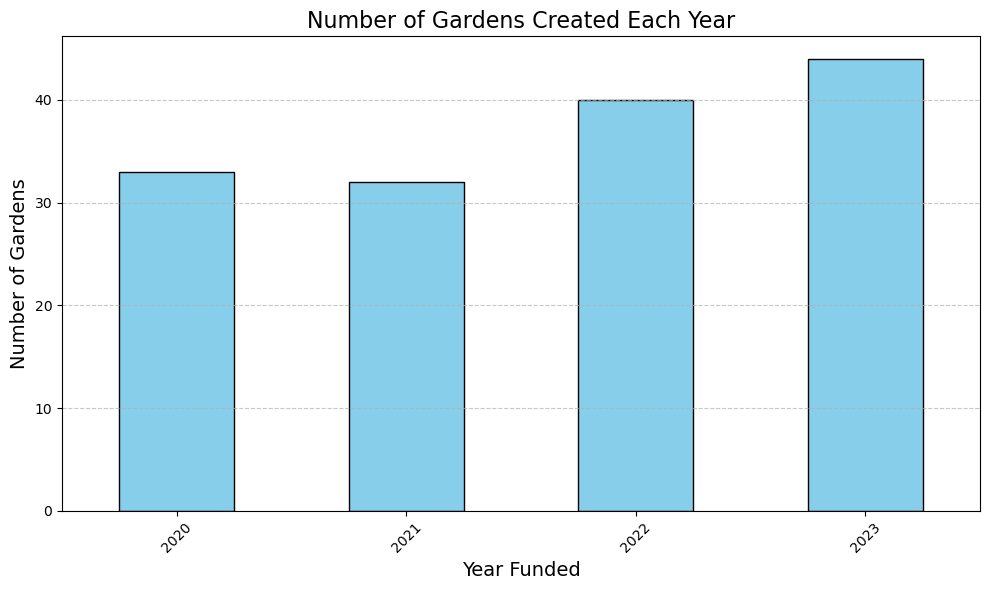

In [24]:
# 1. How many gardens were created each year?
gardens_per_year = pollinateTO_df['YEAR_FUNDED'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
gardens_per_year.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Number of Gardens Created Each Year', fontsize=16)
plt.xlabel('Year Funded', fontsize=14)
plt.ylabel('Number of Gardens', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [25]:
# Count how many times each group appears in the dataset
group_entry_count = pollinateTO_df['GROUP_NAME'].value_counts()

# Get the top 10 groups with the most entries
top_10_groups_by_entries = group_entry_count.head(10)

# Create a bar plot for the top 10 groups by number of entries
plt.figure(figsize=(12, 6))
top_10_groups_by_entries.plot(kind='bar', color='lightgreen', edgecolor='black')
plt.title('Top 10 Groups by Number of Entries in the Dataset', fontsize=16)
plt.xlabel('Group Name', fontsize=14)
plt.ylabel('Number of Entries', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [26]:
# 3. What are the garden types?
garden_types = pollinateTO_df['GARDEN_TYPE'].value_counts()

plt.figure(figsize=(10, 6))
garden_types.plot(kind='pie', autopct='%1.1f%%', startangle=140, colors=sns.color_palette("pastel"))
plt.title('Distribution of Garden Types', fontsize=16)
plt.ylabel('')  # Remove y-label for aesthetics
plt.tight_layout()
plt.show()

In [27]:
# 4. What were the main garden types created each year?
garden_types_per_year = pollinateTO_df.groupby(['YEAR_FUNDED', 'GARDEN_TYPE']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 8))
garden_types_per_year.plot(kind='bar', stacked=True, colormap='tab20', figsize=(16, 10))
plt.title('Main Garden Types Created Each Year', fontsize=18)
plt.xlabel('Year Funded', fontsize=16)
plt.ylabel('Number of Gardens', fontsize=16)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

<Figure size 1200x800 with 0 Axes>

let's combine incomes, gardens with year funded and neighbourhood profiles. first let's bring in year funded for gardens.

In [28]:
# --- STEP 1: Prepare PollinateTO Garden Data ---
pollinateTO_df['geometry'] = pollinateTO_df['geometry'].apply(loads)
pollinateTO_gdf = gpd.GeoDataFrame(pollinateTO_df, geometry='geometry')
pollinateTO_gdf.set_crs(epsg=4326, inplace=True)

def extract_first_point(geometry):
    if geometry.geom_type == "MultiPoint":
        return list(geometry.geoms)[0]
    elif geometry.geom_type == "Point":
        return geometry
    return None

pollinateTO_gdf['geometry'] = pollinateTO_gdf['geometry'].apply(extract_first_point)
pollinateTO_gdf = pollinateTO_gdf[pollinateTO_gdf['geometry'].notnull()]

# --- STEP 2: Create Folium Map ---
toronto_map = folium.Map(location=[43.7, -79.4], zoom_start=11, tiles="CartoDB positron")

# Add neighborhood geometries with income coloring
income_colormap = cm.ScalarMappable(
    norm=Normalize(vmin=merged_gdf["Average Income Midpoint"].min(), vmax=merged_gdf["Average Income Midpoint"].max()),
    cmap="YlGnBu"
)

for _, row in merged_gdf.iterrows():
    income = row["Average Income Midpoint"]
    color = (
        rgb2hex(income_colormap.to_rgba(income))
        if pd.notna(income)
        else "#d3d3d3"  # Default color for unmatched neighborhoods
    )
    folium.GeoJson(
        row['geometry'],
        style_function=lambda x, color=color: {
            "fillColor": color,
            "color": "black",
            "weight": 0.5,
            "fillOpacity": 0.7,
        },
        tooltip=folium.Tooltip(
            f"<b>Neighborhood:</b> {row['Mapped_NAME']}<br>"
            f"<b>Population:</b> {row['Population, 2016']}<br>"
            f"<b>Average Income:</b> {row['Average Income']}"
        ),
    ).add_to(toronto_map)

# Add gardens with year-funded coloring
years = pollinateTO_gdf['YEAR_FUNDED'].unique()
year_colormap = cm.ScalarMappable(
    norm=Normalize(vmin=years.min(), vmax=years.max()), cmap="viridis"
)

for _, row in pollinateTO_gdf.iterrows():
    year = row["YEAR_FUNDED"]
    garden_color = rgb2hex(year_colormap.to_rgba(year))
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=5,
        color=garden_color,
        fill=True,
        fill_color=garden_color,
        fill_opacity=0.8,
        tooltip=folium.Tooltip(
            f"<b>Project:</b> {row['PROJECT_NAME']}<br>"
            f"<b>Year Funded:</b> {row['YEAR_FUNDED']}<br>"
            f"<b>Group:</b> {row['GROUP_NAME']}<br>"
            f"<b>Garden Type:</b> {row['GARDEN_TYPE']}"
        ),
    ).add_to(toronto_map)

# --- STEP 3: Add Legends ---

# Year-Funded Legend

# Generate year_colors mapping
year_colors = {year: rgb2hex(year_colormap.to_rgba(year)) for year in sorted(pollinateTO_gdf['YEAR_FUNDED'].unique())}

# --- Custom Year-Funded Legend (List Format) ---
legend_html = """
<div style="position: fixed; 
            bottom: 50px; left: 50px; width: 200px; height: auto; 
            background-color: white; z-index:9999; font-size:14px;
            border:2px solid grey; padding: 10px;">
    <b>Year Funded Legend:</b><br>
"""
# Create the legend items
for year, color in year_colors.items():
    legend_html += f"<i style='background: {color}; width: 15px; height: 15px; float: left; margin-right: 5px;'></i>{year}<br>"

legend_html += "</div>"

# Add the legend to the map
legend = Element(legend_html)
toronto_map.get_root().html.add_child(legend)

# Save the map
toronto_map.save("toronto_neighborhoods_with_gardens_and_legends.html")
print("Map with income, gardens, and legends saved as 'toronto_neighborhoods_with_gardens_and_legends.html'.")


Map with income, gardens, and legends saved as 'toronto_neighborhoods_with_gardens_and_legends.html'.


now let's bring in garden type. 

In [29]:
from matplotlib.colors import ListedColormap
import random
from matplotlib import cm
from matplotlib.colors import ListedColormap
import seaborn as sns

# --- STEP 1: Create Folium Map ---
toronto_map = folium.Map(location=[43.7, -79.4], zoom_start=11, tiles="CartoDB positron")

# Add neighborhood geometries with income coloring
income_colormap = cm.ScalarMappable(
    norm=Normalize(vmin=merged_gdf["Average Income Midpoint"].min(), vmax=merged_gdf["Average Income Midpoint"].max()),
    cmap="YlGnBu"
)

for _, row in merged_gdf.iterrows():
    income = row["Average Income Midpoint"]
    color = (
        rgb2hex(income_colormap.to_rgba(income))
        if pd.notna(income)
        else "#d3d3d3"  # Default color for unmatched neighborhoods
    )
    folium.GeoJson(
        row['geometry'],
        style_function=lambda x, color=color: {
            "fillColor": color,
            "color": "black",
            "weight": 0.5,
            "fillOpacity": 0.7,
        },
        tooltip=folium.Tooltip(
            f"<b>Neighborhood:</b> {row['Mapped_NAME']}<br>"
            f"<b>Population:</b> {row['Population, 2016']}<br>"
            f"<b>Average Income:</b> {row['Average Income']}"
        ),
    ).add_to(toronto_map)

# --- STEP 2: Add Gardens with Garden Type Coloring ---
# Use a bright qualitative colormap for highly distinct and vibrant colors
garden_types = pollinateTO_gdf['GARDEN_TYPE'].unique()

# Generate distinct bright colors using Seaborn
palette = sns.color_palette("bright", n_colors=len(garden_types))  # "bright" for vibrant colors
type_colors = {g_type: rgb2hex(color) for g_type, color in zip(garden_types, palette)}

# Add garden points with updated vibrant colors
for _, row in pollinateTO_gdf.iterrows():
    g_type = row["GARDEN_TYPE"]
    garden_color = type_colors[g_type]
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=5,
        color=garden_color,
        fill=True,
        fill_color=garden_color,
        fill_opacity=0.8,
        tooltip=folium.Tooltip(
            f"<b>Project:</b> {row['PROJECT_NAME']}<br>"
            f"<b>Garden Type:</b> {row['GARDEN_TYPE']}<br>"
            f"<b>Group:</b> {row['GROUP_NAME']}<br>"
            f"<b>Year Funded:</b> {row['YEAR_FUNDED']}"
        ),
    ).add_to(toronto_map)

# --- STEP 3: Add Garden Type Legend ---
legend_html = """
<div style="position: fixed; 
            bottom: 50px; left: 50px; width: 250px; height: auto; 
            background-color: white; z-index:9999; font-size:14px;
            border:2px solid grey; padding: 10px;">
    <b>Garden Type Legend:</b><br>
"""
for g_type, color in type_colors.items():
    legend_html += f"<i style='background: {color}; width: 15px; height: 15px; float: left; margin-right: 5px;'></i>{g_type}<br>"

legend_html += "</div>"

# Add the legend to the map
legend = Element(legend_html)
toronto_map.get_root().html.add_child(legend)

# Save the updated map
toronto_map.save("toronto_neighborhoods_with_bright_garden_types.html")
print("Map with brighter garden type colors saved as 'toronto_neighborhoods_with_bright_garden_types.html'.")


Map with brighter garden type colors saved as 'toronto_neighborhoods_with_bright_garden_types.html'.


# Now we want to introduce schools to our analysis

In [30]:
schools_df.head()

_id  OBJECTID    GEO_ID                               NAME  \
0    1         1    330677      A PLUS ACADEMY OF ADVANCEMENT   
1    2         2    524780      A R S ARMENIAN PRIVATE SCHOOL   
2    3         3  20258267               A Y J GLOBAL ACADEMY   
3    4         4    517961       A Y JACKSON SECONDARY SCHOOL   
4    5         5  13967401  ABACUS MONTESSORI LEARNING CENTRE   

                      BOARD_NAME       SOURCE_ADDRESS  ADDRESS_POINT_ID  \
0                            NaN  2425 EGLINTON AVE E            330677   
1                            NaN      50 HALLCROWN PL            524780   
2                            NaN         4 LANSING SQ          20258267   
3  Toronto District School Board       50 FRANCINE DR            517961   
4                            NaN    4 CREDIT UNION DR          13967401   

  ADDRESS_NUMBER         ADDRESS_FULL POSTAL_CODE MUNICIPALITY     CITY  \
0           2425  2425 Eglinton Ave E     M1K 5G8  Scarborough  Toronto   
1             50      50 Hallcrown Pl     M2J 1P7   North York  Toronto   
2              4         4 Lansing Sq     M2J 5A2   North York  Toronto   
3             50       50 Francine Dr     M2H 2G6   North York  Toronto   
4              4    4 Credit Union Dr     M4A 2N8   North York  Toronto   

                       PLACE_NAME  CENTRELINE_ID  \
0                             NaN         111254   
1                             NaN         438652   
2                             NaN         438287   
3  A. Y. Jackson Secondary School         436260   
4         Latvian Canadian Centre         444179   

                                          geometry  
0   MULTIPOINT (-79.267103936897 43.7320819460129)  
1    MULTIPOINT (-79.323156147744 43.770053062482)  
2   MULTIPOINT (-79.3252164120635 43.774082570705)  
3  MULTIPOINT (-79.3665552934095 43.8052613014219)  
4   MULTIPOINT (-79.3190099774403 43.725432232812)

In [31]:
from shapely.wkt import loads
import geopandas as gpd

# Convert geometry to Shapely objects and create GeoDataFrame
schools_df['geometry'] = schools_df['geometry'].apply(loads)
schools_gdf = gpd.GeoDataFrame(schools_df, geometry='geometry', crs="EPSG:4326")

# Extract the first point from MULTIPOINT geometries
def extract_first_point(geometry):
    if geometry.geom_type == "MultiPoint":
        return list(geometry.geoms)[0]
    elif geometry.geom_type == "Point":
        return geometry
    return None

schools_gdf['geometry'] = schools_gdf['geometry'].apply(extract_first_point)

# Drop rows with null geometries (if any)
schools_gdf = schools_gdf[schools_gdf['geometry'].notnull()]

# Display the cleaned GeoDataFrame
schools_gdf.head()

_id  OBJECTID    GEO_ID                               NAME  \
0    1         1    330677      A PLUS ACADEMY OF ADVANCEMENT   
1    2         2    524780      A R S ARMENIAN PRIVATE SCHOOL   
2    3         3  20258267               A Y J GLOBAL ACADEMY   
3    4         4    517961       A Y JACKSON SECONDARY SCHOOL   
4    5         5  13967401  ABACUS MONTESSORI LEARNING CENTRE   

                      BOARD_NAME       SOURCE_ADDRESS  ADDRESS_POINT_ID  \
0                            NaN  2425 EGLINTON AVE E            330677   
1                            NaN      50 HALLCROWN PL            524780   
2                            NaN         4 LANSING SQ          20258267   
3  Toronto District School Board       50 FRANCINE DR            517961   
4                            NaN    4 CREDIT UNION DR          13967401   

  ADDRESS_NUMBER         ADDRESS_FULL POSTAL_CODE MUNICIPALITY     CITY  \
0           2425  2425 Eglinton Ave E     M1K 5G8  Scarborough  Toronto   
1             50      50 Hallcrown Pl     M2J 1P7   North York  Toronto   
2              4         4 Lansing Sq     M2J 5A2   North York  Toronto   
3             50       50 Francine Dr     M2H 2G6   North York  Toronto   
4              4    4 Credit Union Dr     M4A 2N8   North York  Toronto   

                       PLACE_NAME  CENTRELINE_ID                    geometry  
0                             NaN         111254   POINT (-79.2671 43.73208)  
1                             NaN         438652  POINT (-79.32316 43.77005)  
2                             NaN         438287  POINT (-79.32522 43.77408)  
3  A. Y. Jackson Secondary School         436260  POINT (-79.36656 43.80526)  
4         Latvian Canadian Centre         444179  POINT (-79.31901 43.72543)

In [32]:
import folium
from matplotlib.colors import rgb2hex, Normalize
from matplotlib import cm
from branca.element import Element

# Initialize the map
toronto_map = folium.Map(location=[43.7, -79.4], zoom_start=11, tiles="CartoDB positron")

# --- Add Income by Neighborhood ---
# Normalize income values for color mapping
income_colormap = cm.ScalarMappable(
    norm=Normalize(vmin=merged_gdf["Average Income Midpoint"].min(), vmax=merged_gdf["Average Income Midpoint"].max()),
    cmap="YlGnBu"
)

# Add neighborhood shapes with income coloring
for _, row in merged_gdf.iterrows():
    income = row["Average Income Midpoint"]
    color = rgb2hex(income_colormap.to_rgba(income)) if pd.notna(income) else "#d3d3d3"  # Default for unmatched
    folium.GeoJson(
        row['geometry'],
        style_function=lambda x, color=color: {
            "fillColor": color,
            "color": "black",
            "weight": 0.5,
            "fillOpacity": 0.7,
        },
        tooltip=folium.Tooltip(
            f"<b>Neighborhood:</b> {row['Mapped_NAME']}<br>"
            f"<b>Population:</b> {row['Population, 2016']}<br>"
            f"<b>Average Income:</b> {row['Average Income']}"
        ),
    ).add_to(toronto_map)

# --- Add Gardens ---
# Distinguish School Learning Gardens from other gardens
for _, row in pollinateTO_gdf.iterrows():
    is_school_garden = row["GARDEN_TYPE"] == "School Learning Garden"
    color = "blue" if is_school_garden else "green"
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=5,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.8,
        tooltip=folium.Tooltip(
            f"<b>Project:</b> {row['PROJECT_NAME']}<br>"
            f"<b>Garden Type:</b> {row['GARDEN_TYPE']}<br>"
            f"<b>Group:</b> {row['GROUP_NAME']}<br>"
            f"<b>Year Funded:</b> {row['YEAR_FUNDED']}"
        ),
    ).add_to(toronto_map)

# --- Add Schools ---
# Add school locations as red points
# Add Schools as Smaller Points
for _, row in schools_gdf.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=2,  # Reduced radius for smaller points
        color="red",
        fill=True,
        fill_color="red",
        fill_opacity=0.8,
        tooltip=folium.Tooltip(
            f"<b>School Name:</b> {row['NAME']}<br>"
            f"<b>Board:</b> {row['BOARD_NAME']}<br>"
            f"<b>Address:</b> {row['ADDRESS_FULL']}"
        ),
    ).add_to(toronto_map)
    
# --- Add Legends ---
legend_html = """
<div style="position: fixed; 
            bottom: 50px; left: 50px; width: 250px; height: auto; 
            background-color: white; z-index:9999; font-size:14px;
            border:2px solid grey; padding: 10px;">
    <b>Legend:</b><br>
    <i style='background: blue; width: 15px; height: 15px; float: left; margin-right: 5px;'></i>School Learning Garden<br>
    <i style='background: green; width: 15px; height: 15px; float: left; margin-right: 5px;'></i>Other Garden<br>
    <i style='background: red; width: 15px; height: 15px; float: left; margin-right: 5px;'></i>School Location<br>
</div>
"""

legend = Element(legend_html)
toronto_map.get_root().html.add_child(legend)

# Save the map
map_path = "toronto_income_gardens_schools.html"
toronto_map.save(map_path)
map_path


'toronto_income_gardens_schools.html'

# Now let's take a look at existing parks

In [33]:
parks_df.head()

_id  LOCATIONID  ASSET_ID               ASSET_NAME  TYPE   AMENITIES  \
0    1         298      1126   WILLIAMSON PARK RAVINE  Park         NaN   
1    2        2342      1328       GLENELLEN PARKETTE  Park         NaN   
2    3        2281      1317             GATEWAY PARK  Park         NaN   
3    4        1030       964           SMITHWOOD PARK  Park  Playground   
4    5        2544       816  PETER STREET BASIN PARK  Park         NaN   

              ADDRESS PHONE  \
0   1680 GERRARD ST E   NaN   
1   63 GLENELLEN DR E   NaN   
2  40 EAST LIBERTY ST   NaN   
3     79 SMITHWOOD DR   NaN   
4   370 QUEENS QUAY W   NaN   

                                                 URL  \
0  https://www.toronto.ca/data/parks/prd/faciliti...   
1  https://www.toronto.ca/data/parks/prd/faciliti...   
2  https://www.toronto.ca/data/parks/prd/faciliti...   
3  https://www.toronto.ca/data/parks/prd/faciliti...   
4  https://www.toronto.ca/data/parks/prd/faciliti...   

                                          geometry  
0  MULTIPOINT (-79.3173566254804 43.6780549678585)  
1   MULTIPOINT (-79.4954482404427 43.640619013426)  
2  MULTIPOINT (-79.4119174331757 43.6393331052003)  
3  MULTIPOINT (-79.5507058668245 43.6408874593971)  
4  MULTIPOINT (-79.3897486591197 43.6384910224043)

In [34]:
# Convert geometry to Shapely objects and create GeoDataFrame
parks_df['geometry'] = parks_df['geometry'].apply(loads)
parks_gdf = gpd.GeoDataFrame(parks_df, geometry='geometry', crs="EPSG:4326")

# Extract the first point from MULTIPOINT geometries
parks_gdf['geometry'] = parks_gdf['geometry'].apply(extract_first_point)

# Drop rows with null geometries (if any)
parks_gdf = parks_gdf[parks_gdf['geometry'].notnull()]

# Display the cleaned GeoDataFrame
parks_gdf.head()

_id  LOCATIONID  ASSET_ID               ASSET_NAME  TYPE   AMENITIES  \
0    1         298      1126   WILLIAMSON PARK RAVINE  Park         NaN   
1    2        2342      1328       GLENELLEN PARKETTE  Park         NaN   
2    3        2281      1317             GATEWAY PARK  Park         NaN   
3    4        1030       964           SMITHWOOD PARK  Park  Playground   
4    5        2544       816  PETER STREET BASIN PARK  Park         NaN   

              ADDRESS PHONE  \
0   1680 GERRARD ST E   NaN   
1   63 GLENELLEN DR E   NaN   
2  40 EAST LIBERTY ST   NaN   
3     79 SMITHWOOD DR   NaN   
4   370 QUEENS QUAY W   NaN   

                                                 URL  \
0  https://www.toronto.ca/data/parks/prd/faciliti...   
1  https://www.toronto.ca/data/parks/prd/faciliti...   
2  https://www.toronto.ca/data/parks/prd/faciliti...   
3  https://www.toronto.ca/data/parks/prd/faciliti...   
4  https://www.toronto.ca/data/parks/prd/faciliti...   

                     geometry  
0  POINT (-79.31736 43.67805)  
1  POINT (-79.49545 43.64062)  
2  POINT (-79.41192 43.63933)  
3  POINT (-79.55071 43.64089)  
4  POINT (-79.38975 43.63849)

In [35]:
# Initialize a new Folium map
toronto_map_parks = folium.Map(location=[43.7, -79.4], zoom_start=11, tiles="CartoDB positron")

# --- Add Neighborhood Income Layers ---
# Normalize income values for color mapping
income_colormap = cm.ScalarMappable(
    norm=Normalize(vmin=merged_gdf["Average Income Midpoint"].min(), vmax=merged_gdf["Average Income Midpoint"].max()),
    cmap="YlGnBu"
)

for _, row in merged_gdf.iterrows():
    income = row["Average Income Midpoint"]
    color = rgb2hex(income_colormap.to_rgba(income)) if pd.notna(income) else "#d3d3d3"
    folium.GeoJson(
        row['geometry'],
        style_function=lambda x, color=color: {
            "fillColor": color,
            "color": "black",
            "weight": 0.5,
            "fillOpacity": 0.7,
        },
        tooltip=folium.Tooltip(
            f"<b>Neighborhood:</b> {row['Mapped_NAME']}<br>"
            f"<b>Population:</b> {row.get('Population, 2016', 'N/A')}<br>"
            f"<b>Average Income:</b> {row.get('Average Income', 'N/A')}"
        ),
    ).add_to(toronto_map_parks)

# --- Add Gardens ---
# Add all gardens as one group
for _, row in pollinateTO_gdf.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=4,  # Adjusted size
        color="green",  # Uniform color for all gardens
        fill=True,
        fill_color="green",
        fill_opacity=0.8,
        tooltip=folium.Tooltip(
            f"<b>Project:</b> {row['PROJECT_NAME']}<br>"
            f"<b>Garden Type:</b> {row['GARDEN_TYPE']}<br>"
            f"<b>Group:</b> {row['GROUP_NAME']}<br>"
            f"<b>Year Funded:</b> {row['YEAR_FUNDED']}"
        ),
    ).add_to(toronto_map_parks)


# --- Add Parks ---
for _, row in parks_gdf.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=3,  # Smaller size for parks
        color="orange",
        fill=True,
        fill_color="orange",
        fill_opacity=0.8,
        tooltip=folium.Tooltip(
            f"<b>Park Name:</b> {row['ASSET_NAME']}<br>"
            f"<b>Type:</b> {row['TYPE']}<br>"
            f"<b>Address:</b> {row['ADDRESS']}"
        ),
    ).add_to(toronto_map_parks)

legend_html = """
<div style="position: fixed; 
            bottom: 50px; left: 50px; width: 250px; height: auto; 
            background-color: white; z-index:9999; font-size:14px;
            border:2px solid grey; padding: 10px;">
    <b>Legend:</b><br>
    <i style='background: green; width: 15px; height: 15px; float: left; margin-right: 5px;'></i>Garden<br>
    <i style='background: orange; width: 15px; height: 15px; float: left; margin-right: 5px;'></i>Park<br>
</div>
"""


legend = Element(legend_html)
toronto_map_parks.get_root().html.add_child(legend)

# Save the map
parks_map_path = "toronto_income_gardens_parks.html"
toronto_map_parks.save(parks_map_path)
parks_map_path

'toronto_income_gardens_parks.html'

# Lastly let's bring in development applications data

In [44]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import folium
from pyproj import Transformer

# Load the dataset
file_path = "Development_Applications_development_applications.csv"  # Replace with actual file path
development_df = pd.read_csv(file_path)

# --- Step 1: Transform X, Y to Latitude and Longitude ---
# Attempt using Web Mercator (EPSG:3857) -> WGS84 (EPSG:4326)
transformer = Transformer.from_crs("EPSG:3857", "EPSG:4326", always_xy=True)

# Apply transformation to create latitude and longitude columns
development_df["LATITUDE"], development_df["LONGITUDE"] = zip(
    *development_df.apply(
        lambda row: transformer.transform(row["X"], row["Y"]) if pd.notna(row["X"]) and pd.notna(row["Y"]) else (None, None),
        axis=1
    )
)

# Debug Step: Check Transformed Coordinates
print("Transformed Coordinates (Alternative CRS, Sample):")
print(development_df[["X", "Y", "LATITUDE", "LONGITUDE"]].head())

# --- Step 2: Filter Valid Development Points ---
# Filter points within a plausible range for Toronto
valid_development_df = development_df[
    development_df["LATITUDE"].notna() & 
    development_df["LONGITUDE"].notna() & 
    (development_df["LATITUDE"].between(43.6, 43.9)) & 
    (development_df["LONGITUDE"].between(-79.6, -79.0))
]

print("\nValid Development Points Count:", len(valid_development_df))
if len(valid_development_df) == 0:
    print("No valid development points found! Please check your data.")

# --- Step 3: Create a GeoDataFrame ---
development_gdf = gpd.GeoDataFrame(
    valid_development_df,
    geometry=gpd.points_from_xy(valid_development_df["LONGITUDE"], valid_development_df["LATITUDE"]),
    crs="EPSG:4326"
)

# --- Step 4: Initialize Folium Map ---
toronto_map_developments = folium.Map(location=[43.7, -79.4], zoom_start=11, tiles="CartoDB positron")

# --- Step 5: Add Development Points ---
for _, row in development_gdf.iterrows():
    description = row["DESCRIPTION"] if pd.notna(row["DESCRIPTION"]) else "No description available"
    folium.CircleMarker(
        location=[row["LATITUDE"], row["LONGITUDE"]],
        radius=5,
        color="red",
        fill=True,
        fill_color="red",
        fill_opacity=0.8,
        tooltip=folium.Tooltip(
            f"<b>Development Address:</b> {row['STREET_NUM']} {row['STREET_NAME']} {row.get('STREET_TYPE', '')}<br>"
            f"<b>Status:</b> {row['STATUS']}<br>"
            f"<b>Ward Name:</b> {row['WARD_NAME']}<br>"
            f"<b>Description:</b> {description[:150]}..."  # Truncated description
        ),
    ).add_to(toronto_map_developments)

# --- Step 6: Add Legends ---
legend_html = """
<div style="position: fixed; 
            bottom: 50px; left: 50px; width: 250px; height: auto; 
            background-color: white; z-index:9999; font-size:14px;
            border:2px solid grey; padding: 10px;">
    <b>Legend:</b><br>
    <i style='background: red; width: 15px; height: 15px; float: left; margin-right: 5px;'></i>Development Location<br>
</div>
"""
from branca.element import Element
legend = Element(legend_html)
toronto_map_developments.get_root().html.add_child(legend)

# --- Step 7: Save and Display Map ---
map_path = "toronto_development_map.html"
toronto_map_developments.save(map_path)
print(f"Map saved to {map_path}")



Transformed Coordinates (Alternative CRS, Sample):
            X            Y  LATITUDE  LONGITUDE
0  322403.434  4837700.947  2.896199  39.805381
1  322391.759  4837712.879  2.896094  39.805463
2  322405.443  4837725.206  2.896217  39.805548
3  323517.010  4843009.424  2.906203  39.842005
4  323518.740  4842979.297  2.906218  39.841798

Valid Development Points Count: 0
No valid development points found! Please check your data.
Map saved to toronto_development_map.html


In [41]:
print(development_gdf[["LATITUDE", "LONGITUDE"]].head())
print(development_gdf[["LATITUDE", "LONGITUDE"]].describe())
print(development_gdf[["LATITUDE", "LONGITUDE"]].isna().sum())


    LATITUDE  LONGITUDE
0 -83.202977  43.671092
1 -83.203125  43.671196
2 -83.202960  43.671310
3 -83.190912  43.719119
4 -83.190881  43.718849
           LATITUDE     LONGITUDE
count  23442.000000  23442.000000
mean     -83.312266     43.687930
std        0.186810      0.271445
min      -83.560545      2.878003
25%      -83.366312     43.646094
50%      -83.317910     43.683702
75%      -83.285751     43.723248
max      -79.173062     43.834538
LATITUDE     774
LONGITUDE    774
dtype: int64
